# Predictive Policing in San Francisco, SF
Using crime data set in SF in 2016 creates the model for predicting it in 2017.

## For a blog post explaining the motivation behind this project and an interactive map with the predictions visit:

 http://www.orlandotorres.org/predictive-policing-sf.html

In [ ]:
!pip install geopandas shapely

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [8]:
crime17 = pd.read_csv('data/sf_incidents17.csv')
crime16 = pd.read_csv('data/sf_incidents16.csv')


### Find the zip codes for each incident given the latitude and longitude

In [12]:
crime16['geometry'] = crime16.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [13]:
geo_police_data = geopandas.GeoDataFrame(crime16, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [16]:
sf = geopandas.read_file('data/zipcodes_geo.json')
sf.crs = {'init': 'epsg:4326'}
sf = sf.set_geometry('geometry')

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [17]:
crime16 = geopandas.tools.sjoin(geo_police_data, sf, how='left')

### Find which zip codes, day of week, and hour have the most crimes

In [18]:
day_time_zip_16 = crime16[['Date', 'DayOfWeek', 'Time', 'zip']]

In [19]:
day_time_zip_16.loc[:, 'Date'] = pd.to_datetime(day_time_zip_16['Date'])

day_time_zip_16.loc[:, 'Hour'] = pd.to_datetime(day_time_zip_16['Time'])
day_time_zip_16.loc[:, 'Hour'] = day_time_zip_16.Hour.apply(lambda x: x.hour)

/var/folders/xb/s7vwrt4153xbxzr8hc8tbdtr0000gn/T/ipykernel_39722/3030326500.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_time_zip_16.loc[:, 'Date'] = pd.to_datetime(day_time_zip_16['Date'])
/var/folders/xb/s7vwrt4153xbxzr8hc8tbdtr0000gn/T/ipykernel_39722/3030326500.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_time_zip_16.loc[:, 'Hour'] = pd.to_datetime(day_time_zip_16['Time'])
/var/folders/xb/s7vwrt4153xbxzr8hc8tbdtr0000gn/T/ipykernel_39722/3030326500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [20]:
day_time_zip_16.head()

,Date,DayOfWeek,Time,zip,Hour
0,2016-01-29 00:00:00,Friday,11:00,94103,11
1,2016-01-29 00:00:00,Friday,11:00,94103,11
2,2016-02-18 00:00:00,Thursday,22:00,94109,22
3,2016-10-03 00:00:00,Monday,01:18,94102,1
4,2016-04-25 00:00:00,Monday,14:59,94124,14


## Remove data from November and December because I don't have that data for 2017 to compare it to

First convert the object to datetime format:

In [40]:
day_time_zip_16['Date']=pd.to_datetime(day_time_zip_16['Date'])

/var/folders/xb/s7vwrt4153xbxzr8hc8tbdtr0000gn/T/ipykernel_39722/1204656020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_time_zip_16['Date']=pd.to_datetime(day_time_zip_16['Date'])


In [43]:
day_time_zip_16_final = day_time_zip_16[day_time_zip_16.Date.dt.month < 11]

In [44]:
day_time_zip_16.head()

,Date,DayOfWeek,Time,zip,Hour
0,2016-01-29,Friday,11:00,94103,11
1,2016-01-29,Friday,11:00,94103,11
2,2016-02-18,Thursday,22:00,94109,22
3,2016-10-03,Monday,01:18,94102,1
4,2016-04-25,Monday,14:59,94124,14


## Combine all the crimes into hours and days and zip codes

In [45]:
day_time_zip_16_final = day_time_zip_16[['DayOfWeek', 'zip', 'Hour']]

In [46]:
day_time_zip_16_final.loc[:, 'Crimes'] = 1

/var/folders/xb/s7vwrt4153xbxzr8hc8tbdtr0000gn/T/ipykernel_39722/1087175764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_time_zip_16_final.loc[:, 'Crimes'] = 1


In [47]:
hour_totals_16 = day_time_zip_16_final.groupby(['DayOfWeek', 'zip', 'Hour']).sum().reset_index()

In [48]:
hour_totals_16.sort_values('Crimes', ascending = False).head()

,DayOfWeek,zip,Hour,Crimes
41,Friday,94103,17,265
650,Monday,94103,17,258
3699,Wednesday,94103,18,257
2482,Thursday,94103,18,257
42,Friday,94103,18,253


## Create dummy variables to start doing analysis

In [64]:
hour_totals_16 = hour_totals_16[['Crimes', 'Hour', 'DayOfWeek', 'zip']]

In [65]:
totals_dummies_16 = pd.get_dummies(hour_totals_16)

In [66]:
X_16 = totals_dummies_16.iloc[:, 1:]
y_16 = totals_dummies_16.iloc[:, 0]

In [67]:
from sklearn.linear_model import LinearRegression

In [68]:
model = LinearRegression()
model.fit(X_16,y_16)


/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and wil

LinearRegression()

In [72]:
# predictions = model.predict(X_new)
model.coef_, model.intercept_

(array([  1.4119033 ,   3.10317784,  -1.09658212,   1.09743928,
         -2.09902395,  -0.23872888,  -0.47961383,  -0.28666834,
         56.89681362, 109.9325279 , -30.00936583, -15.20437686,
          9.03371838, -11.6924721 ,  31.24800409,  47.19443266,
        -17.05253415,   5.38490886,  -5.04366257,   3.34919457,
        -18.27192051,  -0.78175781, -10.62104353, -15.06513666,
         -6.07937686, -12.7110121 ,  16.87300409, -27.4460184 ,
        -33.34995952, -21.91906869, -15.29366257,   3.84324219,
        -13.23443667, -29.98004153]),
 18.235346075949018)

## Linear Regression with 2016 data

In [73]:
linear_regression =  LinearRegression()

results = linear_regression.fit(X_16,y_16)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and wil

In [75]:
results

LinearRegression()

# Test it with new 2017 data

### Find the zip codes for each incident given the latitude and longitude

In [76]:
crime17['geometry'] = crime17.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [77]:
geo_police_data = geopandas.GeoDataFrame(crime17, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [79]:
sf = geopandas.read_file('data/zipcodes_geo.json')
sf.crs = {'init': 'epsg:4326'}
sf = sf.set_geometry('geometry')

In [80]:
crime17 = geopandas.tools.sjoin(geo_police_data, sf, how='left')

### Find which zip codes, day of week, and hour have the most crimes

In [81]:
day_time_zip_17 = crime17[['DayOfWeek', 'Time', 'zip']]

In [82]:
day_time_zip_17['Hour'] = pd.to_datetime(day_time_zip_17['Time'])
day_time_zip_17['Hour'] = day_time_zip_17.Hour.apply(lambda x: x.hour)

/var/folders/xb/s7vwrt4153xbxzr8hc8tbdtr0000gn/T/ipykernel_39722/1512495975.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_time_zip_17['Hour'] = pd.to_datetime(day_time_zip_17['Time'])
/var/folders/xb/s7vwrt4153xbxzr8hc8tbdtr0000gn/T/ipykernel_39722/1512495975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_time_zip_17['Hour'] = pd.to_datetime(day_time_zip_17['Time'])
/var/folders/xb/s7vwrt4153xbxzr8hc8tbdtr0000gn/T/ipykernel_39722/1512495975.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

## Combine all the crimes into hours and days and zip codes

In [83]:
day_time_zip_17 = day_time_zip_17[['DayOfWeek', 'zip', 'Hour']]

In [84]:
day_time_zip_17['Crimes'] = 1

In [85]:
hour_totals_17 = day_time_zip_17.groupby(['DayOfWeek', 'zip', 'Hour']).count().reset_index()

In [86]:
hour_totals_17.sort_values('Crimes', ascending = False).head()

,DayOfWeek,zip,Hour,Crimes
2465,Thursday,94103,18,227
2466,Thursday,94103,19,220
3067,Tuesday,94103,18,213
41,Friday,94103,17,213
43,Friday,94103,19,201


## Create dummy variables to start doing analysis

In [87]:
hour_totals_17 = hour_totals_17[['Crimes', 'Hour', 'DayOfWeek', 'zip']]

In [88]:
totals_dummies_17 = pd.get_dummies(hour_totals_17)

In [94]:
X_17 = totals_dummies_17.iloc[:, 1:]
y_17 = totals_dummies_17.iloc[:, 0]

# Testing the different models

## Linear Regression

In [89]:
linear_regression =  LinearRegression()
results = linear_regression.fit(X_16,y_16)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and wil

In [96]:
y_pred=results.predict(X_17)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [98]:
from sklearn.metrics import r2_score
r2_score(y_17, y_pred)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.6386917837250611

## Random Forest

In [99]:
rf = RandomForestRegressor()
rf.fit(X_16, y_16)
rf.score(X_17,y_17)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and wil

0.8095761096317124

In [100]:
list(zip(X_16.columns, rf.feature_importances_))

[('Hour', 0.2442830253667614),
 ('DayOfWeek_Friday', 0.007021712981669595),
 ('DayOfWeek_Monday', 0.003959793566285429),
 ('DayOfWeek_Saturday', 0.008301659665083585),
 ('DayOfWeek_Sunday', 0.009329567741231838),
 ('DayOfWeek_Thursday', 0.004093560794599571),
 ('DayOfWeek_Tuesday', 0.003656631812232754),
 ('DayOfWeek_Wednesday', 0.00457161712451095),
 ('zip_94102', 0.10868364938058758),
 ('zip_94103', 0.35171062382316326),
 ('zip_94104', 0.006768661472260507),
 ('zip_94105', 0.0009770464975403063),
 ('zip_94107', 0.013977436535628562),
 ('zip_94108', 0.0009065168221515718),
 ('zip_94109', 0.04805890849273949),
 ('zip_94110', 0.08531914967236078),
 ('zip_94111', 0.0005150284389233872),
 ('zip_94112', 0.01192407031420646),
 ('zip_94114', 0.002500942575567784),
 ('zip_94115', 0.010742651850431575),
 ('zip_94116', 0.0006922486050078764),
 ('zip_94117', 0.008062955067299217),
 ('zip_94118', 0.0009310318158518833),
 ('zip_94121', 0.0004897839406408802),
 ('zip_94122', 0.0025509475730058425),

## KNN

In [101]:
knn = KNeighborsRegressor()
knn.fit(X_16, y_16)
knn.score(X_17,y_17)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and wil

0.7327464545918523

## SVM

In [102]:
svm = SVR()
svm.fit(X_16, y_16)
svm.score(X_17,y_17)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and wil

0.13401392445832772

## XGBoost

In [103]:
xgb = XGBRegressor()
xgb.fit(X_16, y_16)
xgb.score(X_17,y_17)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categoric

0.8146436419430099

## MLP Regressor

In [104]:
mlp = MLPRegressor(hidden_layer_sizes = (100,100,100,100), random_state=444)
mlp.fit(X_16,y_16)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and wil

MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), random_state=444)

In [105]:
mlp.score(X_17, y_17)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and wil

0.8231209796331261

## Combine predictions and actual results into one dataframe

In [106]:
mlp_predicts = mlp.predict(X_16)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [107]:
xgb_predicts = xgb.predict(X_16)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categoric

In [108]:
hour_totals_17['Predicted_mlp'] = pd.Series(mlp_predicts)
hour_totals_17['Predicted_xgb'] = pd.Series(xgb_predicts)

### Divide by 365 to get the number of crime incidents each day

In [109]:
hour_totals_17['Crimes'] = hour_totals_17['Crimes']/365
hour_totals_17['Predicted_mlp'] = hour_totals_17['Predicted_mlp']/365
hour_totals_17['Predicted_xgb'] = hour_totals_17['Predicted_xgb']/365


In [110]:
hour_totals_17 = np.round(hour_totals_17,2)

In [112]:
hour_totals_17.to_json("data/crime_predictions.json", orient='records', double_precision=2)

## Create a quick Chloropleth map as a sanity check

In [113]:
chloropleth_data = hour_totals_17.merge(sf)
chloropleth_data = geopandas.GeoDataFrame(chloropleth_data, geometry='geometry')
chloropleth_data.crs = {'init': 'epsg:4326'}

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

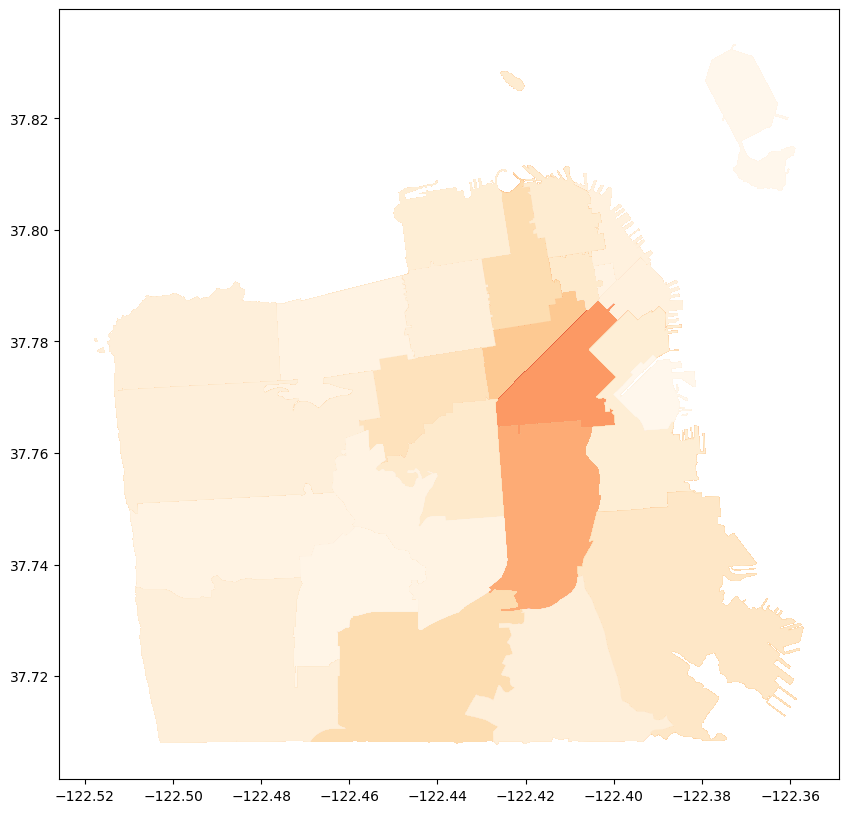

In [114]:
chloropleth_data.plot(column='Crimes', cmap='OrRd', figsize=(13,10))

### Notes
1. different scores, for diffenent models
2. the scores could be arisen if tuning the parameters do.
3. Useg less-code, pycaret.

In [117]:
from pycaret.regression import *
# ...

